In [43]:
import geopy.distance
import numpy as np
import pandas as pd
from random import choices


# 1. Generating data

In [16]:
nestle_coord = (46.466634011, 6.835639010)
density_coord = pd.read_csv('STATPOP2021_WGS84.csv')
distance_cutoff = 20

In [17]:
density_coord_nestle = density_coord[density_coord.apply(
    lambda row: geopy.distance.distance(
        (row.latitude, row.longitude), nestle_coord).km < distance_cutoff,
    axis=1)
].reset_index(drop=True)
total_pop = density_coord_nestle.B21BTOT.sum()
density_coord_nestle['propability_density'] = (density_coord.B21BTOT / total_pop);

density_coord_nestle.to_csv('STATPOP2021_WGS84.csv')

Draw 50 employees location from the density function around Nestle's HQ

In [46]:
n_employees = 10
employee_indexes = choices(density_coord_nestle.index, density_coord_nestle.propability_density, k=n_employees)
employee_locations = density_coord_nestle.iloc[employee_indexes][['latitude', 'longitude']]

# We have to account for the possibility that more than one employees live at the same location
employee_locations_grouped = employee_locations.groupby([employee_locations.index, 'latitude', 'longitude'],
                                                        as_index=False).size()

In [29]:
coordinates_list = list(zip(employee_locations.latitude.tolist(), employee_locations.longitude.tolist()))
coordinates_string = [f'{str(x)},{str(y)}' for x, y in coordinates_list[1:5]]

In [30]:
destinations_fmt = '|'.join(coordinates_string).replace(' ', "%20").replace(',', '%2C')
destinations_fmt

'46.52442399090659%2C6.617574007326364|46.63912431873141%2C6.832636992559628|46.55181875213747%2C6.675836870132429|46.60219461468144%2C6.823915589768784'

# 2. Building the distance matrix

In [35]:
import os
from dotenv import load_dotenv
import requests
import json

load_dotenv()
key = os.getenv('GCP_KEY_0X')

In [32]:
# origin = "Nestle, Vevey"
#
# # The destination parameter is in URL-format (only ASCII) and multiple entries are separated by colons |
# destinations_fmt = '|'.join(coordinates_string).replace(' ', "%20").replace(',', '%2C')
#
# url = f'https://maps.googleapis.com/maps/api/distancematrix/json' \
#       f'?origins={origin}' \
#       f'&destinations={destinations_fmt}' \
#       f'&units=metric' \
#       f'&key={key}'

url = 'https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix'
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': key,
    'X-Goog-FieldMask': 'originIndex,destinationIndex,duration,distanceMeters,status,condition'
}
payload = str({
    'origins': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'destinations': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'travelMode': 'DRIVE',
    'routingPreference': 'TRAFFIC_AWARE'
})

response = requests.request('POST', url, headers=headers, data=payload)

response.json()

[{'originIndex': 7,
  'destinationIndex': 2,
  'status': {},
  'distanceMeters': 660,
  'duration': '102s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 9,
  'destinationIndex': 9,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 8,
  'destinationIndex': 8,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 7,
  'destinationIndex': 7,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 0,
  'destinationIndex': 0,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 5,
  'destinationIndex': 5,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 6,
  'destinationIndex': 6,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 4,
  'destinationIndex': 4,
  'status': {},
  'duration': '0s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 7,
  'destinationIndex': 4,
  'status': {},
  'dista

In [157]:
distance_matrix = [[0]* n_employees for _ in range(n_employees)]
for distance in test:
    distance_matrix[distance['originIndex']][distance['destinationIndex']] = int(distance['duration'][:-1])

distance_matrix

[[0, 1817, 1420, 1473, 1039, 882, 1608, 1431, 1507, 904],
 [1883, 0, 2113, 970, 1858, 1179, 537, 2046, 1010, 1737],
 [1457, 2022, 0, 1322, 457, 1399, 2039, 85, 1431, 2127],
 [1571, 813, 1350, 0, 1189, 858, 879, 1285, 199, 1432],
 [1074, 1867, 473, 1191, 0, 1004, 1649, 481, 1287, 1752],
 [1005, 1193, 1423, 856, 1042, 0, 1010, 1430, 896, 799],
 [1702, 494, 2056, 914, 1714, 982, 0, 1973, 952, 1468],
 [1459, 1952, 102, 1257, 454, 1388, 1973, 0, 1355, 2132],
 [1643, 881, 1414, 215, 1256, 933, 943, 1339, 0, 1511],
 [902, 1728, 2060, 1386, 1689, 761, 1382, 2069, 1422, 0]]

# Solving the VRP

In [129]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}s'.format(max_route_distance))

In [ ]:
def get_routes(data, manager, routing, solution) -> [[]]:


In [134]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


data = {
    'distance_matrix': distance_matrix,
    'num_vehicles': 4,
    'office': 0
}

manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'],
                                       data['office'])

routing = pywrapcp.RoutingModel(manager)

def distance_callback(origin: int, destination: int) -> int:
    return data['distance_matrix'][manager.IndexToNode(origin)][manager.IndexToNode(destination)]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    name=dimension_name,
    slack_max=0, # no slack
    capacity=8000,
    fix_start_cumul_to_zero=True,
)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [135]:
# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [136]:
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 410888
Route for vehicle 0:
 0 ->  6 ->  1 -> 0
Distance of the route: 3985m

Route for vehicle 1:
 0 ->  9 -> 0
Distance of the route: 1806m

Route for vehicle 2:
 0 ->  5 ->  8 ->  3 -> 0
Distance of the route: 3564m

Route for vehicle 3:
 0 ->  2 ->  7 ->  4 -> 0
Distance of the route: 3033m

Maximum of the route distances: 3985m


# 3 Visualisation of the routes

In [150]:
import numpy
import os
from dotenv import load_dotenv
import requests
from IPython.display import Image
import json
import random
load_dotenv()

True

In [151]:
list1 = ["Pl. des Anciens-Fossés 6, 1814 La Tour-de-Peilz","Av. de l'Ile-Heureuse 23, 1800 Vevey","Av. du Général-Guisan 41, 1800 Vevey","Chem. du Petit-Centenaire 6, 1802 Corseaux"]
list2 = ["Rue d'Entre-deux-Villes 8, 1814 La Tour-de-Peilz", "Av. de Traménaz 46, 1814 La Tour-de-Peilz","Rte de Blonay 94, 1814 La Tour-de-Peilz"]
list3 = ["40.737102,-73.990318","40.749825,-73.987963","40.752946,-73.987384","40.755823,-73.986397"]
list4 = ["40.727102,-73.990318","40.739825,-73.977963","40.742946,-73.977384","40.745823,-73.976397"]
list5 = ["Rue de la Madeleine 17, 1800 Vevey", "Rue des Moulins 17, 1800 Vevey", "Chem. Emile-Javelle 2, 1800 Vevey", "Rte de Saint-Légier 11, 1800 Vevey"]
list6 = ["Rue de la Madeleine 17, 1800 Vevey","Rue du Simplon 28, 1800 Vevey", "Av. du Général-Guisan 1, 1800 Vevey"]

shuttles = [list5,list6]

In [152]:
### Function to give a list of directions to follow to go from origin to destination
# Inputs:   origin: a string with the localisation point of the origin
#           destination: a string with the localisation point of the destination
#           key: the maps api key
# Output:   a string of different steps to follow to go from origin to destination

def fct_dir(origin, destination, key):
    url = f'https://maps.googleapis.com/maps/api/directions/json' \
          f'?origin={origin}' \
          f'&destination={destination}' \
          f'&key={key}'

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    direction_dict = json.loads(response.text)

    lat = direction_dict["routes"][0]["legs"][0]["start_location"]["lat"]
    long = direction_dict["routes"][0]["legs"][0]["start_location"]["lng"]

    travel_list = [str(f'{lat},{long}')]

    for l in direction_dict["routes"][0]["legs"][0]["steps"]:
        lat= l["end_location"]["lat"]
        long = l["end_location"]["lng"]
        tmp = f'{lat},{long}'
        travel_list.append(str(tmp))

    travel_list = "|".join(travel_list)

    return(travel_list)

In [153]:
### Funtion to create the path between all localisation points of a list
# Inputs:   list: a list of strings with location points
#           key: the maps api key
# Outputs:  a string with the path to follow

def fct_give_parcours(list, color, key):
    parcours = []

    for i in range(len(list)):
        tmp = fct_dir(list[i%len(list)], list[(i+1)%len(list)], key)
        parcours.append(tmp)

    parcours = "|".join(parcours)

    #color = "0x"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])

    travel_list = f'&path=color:{color}|weight:5|{parcours}'

    return(travel_list)

In [154]:
### Function to create a map with the localisations and path to follow
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           paths: a string with the path to follow
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_maps(shuttles, paths, key):

    labels_list = ""

    colors = ["blue","red","green","orange", "purple","brown","black"]
    c=0

    for s in shuttles:
        s_int = range(len(s))

        labels_s = ""
        for i in s_int:
            labels_s = labels_s + "&markers=size:mid%7Ccolor:"+colors[c]+"%7Clabel:" + str(i) + "%7C" + str(s[i])

        labels_list = labels_list + labels_s
        c+=1



    url = f'https://maps.googleapis.com/maps/api/staticmap' \
          f'?size=400x400' \
          f'{labels_list}' \
          f'{paths}' \
          f'&key={key}'

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    return Image(response.content)

In [155]:
### Function to run the whole algorithm
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_run_maps(shuttles, key):

    paths = ""

    colors = ["blue","red","green","orange", "purple","brown","black"]
    c=0

    for s in shuttles:
        paths = paths + fct_give_parcours(s, colors[c], key)
        c+=1

    return(fct_maps(shuttles, paths, key))

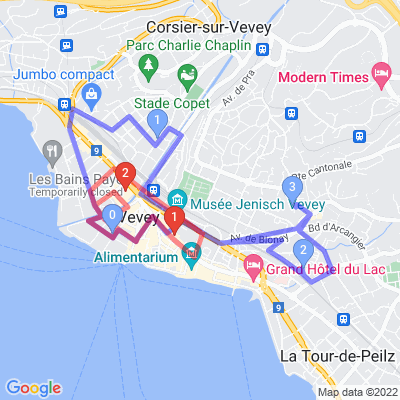

In [156]:
fct_run_maps(shuttles, key)